<a href="https://colab.research.google.com/github/Renass/Yasuo_project/blob/transfer_res_net/classification/classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import files
import torchvision
import glob
from torchvision import transforms
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
import zipfile
from tqdm import tqdm
from PIL import Image
import cv2
import random

#Data preproceccing

In [2]:
from google.colab import drive
drive.mount('/content/drive')


zip_path = '/content/drive/MyDrive/Colab_Notebooks/datasets/stm-data/stm-data.zip'
z = zipfile.ZipFile(zip_path, 'r')
z.extractall()
print(os.listdir())


path = '/content/stm-data/JointDataset'
train_bad_dir = path + '/Train/bad'
train_good_dir = path + '/Train/good'
test_bad_dir = path + '/Test/bad'
test_good_dir = path + '/Test/good'

train_bad_names = glob.glob(train_bad_dir + '/*.npy')
train_good_names = glob.glob(train_good_dir + '/*.npy')
test_bad_names = glob.glob(test_bad_dir + '/*.npy')
test_good_names = glob.glob(test_good_dir + '/*.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.config', 'drive', 'stm-data', 'sample_data']


#Preparing batches

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, names, y, transform = None):
        self.names = names
        self.y = y
        if transform is None:
            self.should_transform = False
        else:
            self.transform = transform
            self.should_transform = True

    def __len__(self):
        return len(self.names)

    def __getitem__(self,idx):
        self.mas = np.load(self.names[idx])
        self.mas = torch.from_numpy(self.mas)
        self.mas = 255*(self.mas - self.mas.min())/(self.mas.max()-self.mas.min())
        self.img =self.mas.numpy()
        self.img = cv2.cvtColor(self.img.astype(np.uint8), cv2.COLOR_GRAY2RGB)

        if self.should_transform:
            self.img_transformed = self.transform(self.img)
        else:
            self.img_transformed = self.img
        return self.img_transformed, self.y

In [4]:
transform = torchvision.transforms.Compose([   
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),              
    transforms.ToTensor(),                  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                    
])


#bad: y=0
#good: y=1
train_bad_dataset = MyDataset(names=train_bad_names, y=0, transform=transform)
train_good_dataset = MyDataset(names=train_good_names, y=1, transform=transform)
train_dataset = train_bad_dataset + train_good_dataset

test_bad_dataset = MyDataset(names=test_bad_names, y=0, transform=transform)
test_good_dataset = MyDataset(names=test_good_names, y=1, transform=transform)
test_dataset = test_bad_dataset + test_good_dataset


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
#torch.Size([batch_size,channels,64,64])

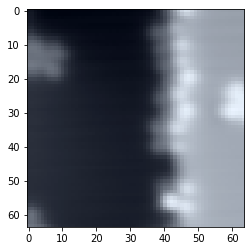

0





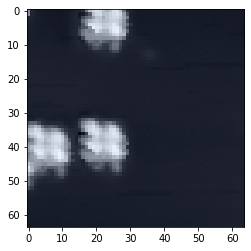

0





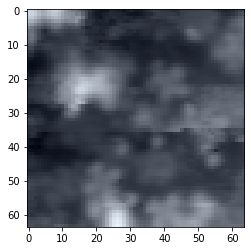

0





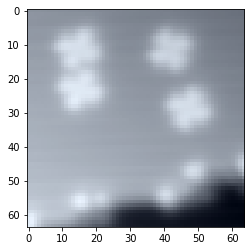

1





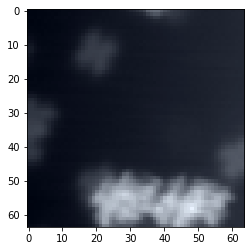

0





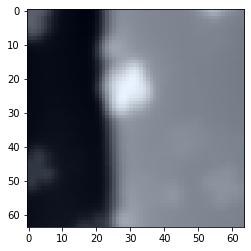

0





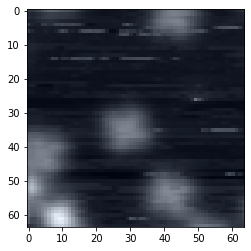

0





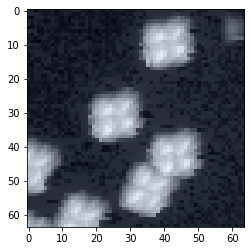

0





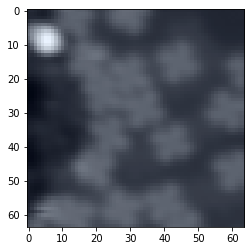

0





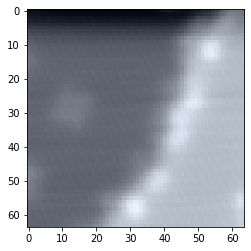

0





In [5]:
def watch_pics(dataset, n=10):
    l = len(dataset)
    for i in range(n):
        r = random.randint(0,l-1)
        data = dataset[r][0]
        data = (data - data.min())/(data.max()-data.min())
        label = dataset[r][1]
        data = data.permute(1,2,0)
        plt.imshow(data)
        plt.show()
        print(str(label)+"\n\n\n")
    return 


watch_pics(train_dataset)

#Train-Test procedures

In [6]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = test_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            scheduler.step()
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [7]:
#old version


def my_ln(x):
  return torch.log(x+10e-45)

def binary_cross_entropy_weighted(pred, target):
    return torch.mean(-2*target*my_ln(pred)-(1-target)*my_ln(1-pred))





def train(model, train_loader, epochs, optimizer):
    model.train()
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for data,target in train_loader:
            data=data.to(device)
            target=target.to(device)
            target = target.unsqueeze(1)
            optimizer.zero_grad()   # zero the gradient buffers
            output = model.forward(data)
            output = output.double()


            #loss = binary_cross_entropy_weighted(output, target)
            
            loss.backward()
            loss_samples.append(loss.data.cpu().numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

In [8]:
#old version




def test(model, device, test_loader):
    model.eval()
    loss=0
    accuracy = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:

            
            data, target = data.to(device), target.to(device)
            output = model.forward(data)
            output = output.double()
            target = target.unsqueeze(1)

            loss+= F.cross_entropy(output,target)
            #loss+= binary_cross_entropy_weighted(output, target)
            pred = target.clone()
            for i,x in enumerate(output):
                ans = 0.
                if x > 0.5:
                    ans = 1.
                pred[i] = ans 


            for i,single_pred in enumerate(pred):
                if single_pred == target[i]:
                    correct+= 1
            total += len(pred)
    loss = loss/len(test_loader)
    accuracy = correct / total
    
    print('Loss: ',loss.data.item())
    print('\n Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, total, 100. * accuracy))

#Main loop

In [9]:
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)



model = torchvision.models.resnet34(pretrained = True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2).to(device)



loss = torch.nn.CrossEntropyLoss()
lr = 10e-3
optimizer=optim.Adam(model.parameters(), lr=lr, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

cpu


In [1]:
train_model(model, loss, optimizer, scheduler, num_epochs=20)

NameError: ignored